In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import ssl
import math
import matplotlib.pyplot as plt
import operator

from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score,accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, TimeDistributed, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D,BatchNormalization,GlobalMaxPooling1D,MaxPooling1D
from keras.regularizers import l2,l1
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
# from keras.optimizers import RMSprop, SGD, adam
from tensorflow.keras.optimizers import RMSprop, SGD, Adam # keep an eye on Adam originally adam


In [2]:
# Import the Arrhythmia dataset from the library and replace missing values by '?'.
# path_data_training = "/content/drive/MyDrive/Maestro_ML/EEG/subject_3/input_files/EEG_multiclass_horizontal_concatenation_1.csv"# 800 samples
# path_data_training = "/content/drive/MyDrive/Maestro_ML/EEG/subject_3/input_files/EEG_multiclass_horizontal_concatenation_1_50.csv"# 500 samples
# path_data_training = "/content/drive/MyDrive/Maestro_ML/EEG/subject_3/input_files/EEG_multiclass_horizontal_concatenation_1_10.csv"
# path_data_training = "/content/drive/MyDrive/Maestro_ML/EEG/subject_2/input_files/EEG_S2_multiclass_horiz_concat_1_10samp_10channels.csv"
path_data_training ='G:\Code_Multimodal_Deep_learning\Data\Testing010\All_Combine\Subject_5_ECG_EMG_signalsAllMydata.csv'
# ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv(path_data_training, delimiter=',', header=None,)

In [3]:
# df = df.drop(index=0)
df

,0,1,2,3,4,5,6,7,8,9,...,31503,31504,31505,31506,31507,31508,31509,31510,31511,31512
0,5.915849,5.912026,5.915416,5.925874,5.943832,5.922989,5.917291,5.923566,5.913180,5.905607,...,2.266685,2.266685,2.266685,2.266685,2.266685,2.266685,2.266685,2.266685,2.266685,5.0
1,5.878706,5.873153,5.880221,5.869114,5.869330,5.870340,5.877841,5.863777,5.875677,5.887144,...,2.189829,2.189829,2.189829,2.189829,2.189829,2.189829,2.189829,2.189829,2.189902,5.0
2,6.224313,6.228424,6.233184,6.248474,6.248690,6.254316,6.251070,6.254604,6.258426,6.255902,...,1.915880,1.915880,1.915880,1.915880,1.915880,1.915880,1.915880,1.915880,1.915880,5.0
3,5.876182,5.878995,5.872432,5.874956,5.874523,5.861253,5.867816,5.872432,5.881014,5.877769,...,1.833312,1.833312,1.833312,1.833312,1.833312,1.833312,1.833312,1.833312,1.822322,5.0
4,5.842934,5.829952,5.838895,5.847117,5.857286,5.858079,5.852526,5.850579,5.847910,5.850434,...,1.690517,1.690517,1.690517,1.690517,1.690517,1.690517,1.690517,1.690517,1.690517,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6635,4.929369,4.760749,4.718053,4.635762,4.551668,4.496495,4.409661,4.228419,4.172164,4.285395,...,1.150569,1.150569,1.150569,1.150569,1.150569,1.150569,1.150569,1.150569,1.145074,5.0
6636,5.269783,5.250743,5.234660,5.227159,5.214971,5.212807,5.202566,5.184031,5.154244,5.154821,...,1.128373,1.128373,1.128373,1.128373,1.128373,1.128373,1.128373,1.128373,1.128373,5.0
6637,4.909968,4.896554,4.892659,4.908526,4.890063,4.886889,4.884726,4.884437,4.888476,4.891577,...,1.156064,1.156064,1.156064,1.156064,1.156064,1.156064,1.156064,1.156064,1.145146,5.0
6638,4.860493,4.853641,4.856743,4.854723,4.868282,4.857608,4.861791,4.864099,4.864604,4.869148,...,1.145002,1.145002,1.145002,1.145002,1.145002,1.145002,1.145002,1.145002,1.145002,5.0


In [5]:
def split_dataset():
    unique_labels = df[122000].unique()
    label_column = 122000
    # Shuffle the rows of the DataFrame
    df_shuffled = df.sample(frac=1)

    # Create two empty DataFrames to hold the data for each part
    part1 = pd.DataFrame()
    part2 = pd.DataFrame()

    # Loop through each unique label
    for label in unique_labels:
        # Get the subset of the DataFrame for this label
        label_subset = df[df[label_column] == label]

        # Split the subset into two parts
        num_rows = label_subset.shape[0]
        num_rows_part1 = num_rows // 2
        num_rows_part2 = num_rows - num_rows_part1
        label_subset_part1 = label_subset.iloc[:num_rows_part1, :]
        label_subset_part2 = label_subset.iloc[num_rows_part1:num_rows_part1+num_rows_part2, :]

        # Add the label subset parts to the corresponding part DataFrame
        part1 = pd.concat([part1, label_subset_part1])
        part2 = pd.concat([part2, label_subset_part2])

    # Write the two parts to CSV files
    part1.to_csv('training_data_part1.csv', index=False)
    part2.to_csv('training_data_part2.csv', index=False)

In [4]:
# Split the frame as Data attribute and Class
df_data = df.iloc[:,:-1]
df_class = df.iloc[:,-1]
# Attribute Scaling

# Normalize the values except for the class labels for each attribute using StandardScaler.
# std_scaler = StandardScaler()
# x_scaled = std_scaler.fit_transform(df_data.values) 


#           / Normalize to [0-1]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_data.values)

df_data = pd.DataFrame(x_scaled, index = df_data.index)

print(df_data.shape)
df_data


(6640, 31512)


,0,1,2,3,4,5,6,7,8,9,...,31502,31503,31504,31505,31506,31507,31508,31509,31510,31511
0,0.920988,0.922933,0.924751,0.929483,0.932957,0.920014,0.916559,0.914379,0.916094,0.920290,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.914323,0.915971,0.918402,0.919252,0.919449,0.910699,0.909549,0.903797,0.909362,0.916980,...,0.975232,0.975232,0.975232,0.975232,0.975232,0.975232,0.975232,0.975232,0.975232,0.975255
2,0.976333,0.979593,0.982082,0.987636,0.988231,0.978638,0.975869,0.972975,0.978069,0.983088,...,0.886947,0.886947,0.886947,0.886947,0.886947,0.886947,0.886947,0.886947,0.886947,0.886947
3,0.913871,0.917018,0.916996,0.920305,0.920390,0.909091,0.907767,0.905328,0.910320,0.915299,...,0.860338,0.860338,0.860338,0.860338,0.860338,0.860338,0.860338,0.860338,0.860338,0.856797
4,0.907905,0.908235,0.910946,0.915286,0.917265,0.908529,0.905051,0.901460,0.904377,0.910399,...,0.814320,0.814320,0.814320,0.814320,0.814320,0.814320,0.814320,0.814320,0.814320,0.814320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6635,0.743993,0.716762,0.708726,0.696924,0.680541,0.667615,0.648665,0.614331,0.603565,0.629831,...,0.640313,0.640313,0.640313,0.640313,0.640313,0.640313,0.640313,0.640313,0.640313,0.638543
6636,0.805070,0.804510,0.801931,0.803531,0.800806,0.794357,0.789558,0.783478,0.779858,0.785695,...,0.633160,0.633160,0.633160,0.633160,0.633160,0.633160,0.633160,0.633160,0.633160,0.633160
6637,0.740512,0.741082,0.740228,0.746093,0.741896,0.736690,0.733080,0.730449,0.732150,0.738503,...,0.642084,0.642084,0.642084,0.642084,0.642084,0.642084,0.642084,0.642084,0.642084,0.638566
6638,0.731635,0.733397,0.733748,0.736395,0.737947,0.731509,0.729005,0.726849,0.727865,0.734481,...,0.638519,0.638519,0.638519,0.638519,0.638519,0.638519,0.638519,0.638519,0.638519,0.638519


In [5]:
# Splitting into training and testing data
# df_data = np.array(df_data).reshape(df_data.shape[0], 335, 100)
X_train, X_test, Y_train, Y_test = train_test_split(df_data, df_class, test_size=0.2, shuffle = True, stratify = df_class, random_state=0)

# Splitting into training and validation data
#X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, shuffle = True, stratify = Y_trainval, random_state=43)

# print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
df_class
# print(Y_train)

0       5.0
1       5.0
2       5.0
3       5.0
4       5.0
       ... 
6635    5.0
6636    5.0
6637    5.0
6638    5.0
6639    5.0
Name: 31512, Length: 6640, dtype: float64

In [6]:
# # from sklearn.utils import class_weight
from  sklearn.utils.class_weight import compute_class_weight
# #ORIGINAL class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
# class_wt = compute_class_weight('balanced', classes = np.unique(Y_train), y = Y_train)
# # class_wt = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
# # class_weights = dict(zip([1,2,3,4,5,6,7,8,9,10,14,15,16], class_wt))
# # class_weights[0] = 0
# # class_weights[11] = 0
# # class_weights[12] = 0
# # class_weights[13] = 0
# # print(class_wt.sum())
# # print(class_weights)

# print(np.bincount(Y_train))
# print(np.bincount(Y_test))

from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weights = compute_class_weight('balanced', classes = np.unique(Y_train), y = Y_train)
class_weights_dict = dict(zip([1,2,3,4,5,6,7,8], class_weights))
class_weights_dict[0] = 0
# class_weights_dict[0] = 0
# class_weights_dict[11] = 0
# class_weights_dict[12] = 0
# class_weights_dict[13] = 0
# print(class_weights.sum())
# print(class_weights_dict)
# class_weights
class_weights_dict

{1: 1.0997929606625259,
 2: 1.1778270509977826,
 3: 1.4434782608695653,
 4: 0.8780165289256199,
 5: 0.7092122830440587,
 0: 0}

In [7]:
# Split the data into train and validation
# X_train_cnn, X_val_cnn, Y_train_cnn, Y_val_cnn = train_test_split(X_train, Y_train, test_size=0.3,  random_state=0)

Xtrain = np.expand_dims(X_train, 2)
Ytrain = to_categorical(Y_train)
Xval = np.expand_dims(X_test, 2)
Yval = to_categorical(Y_test)
print(Xtrain.shape,Ytrain.shape,Xval.shape,Yval.shape)

print(np.bincount(Y_train))
print(np.bincount(Y_test))
# print(np.bincount(Y_train_cnn))
# print(np.bincount(Y_val_cnn))

print(Y_train)
print(Y_test)

(5312, 31512, 1) (5312, 6) (1328, 31512, 1) (1328, 6)
[   0  966  902  736 1210 1498]
[  0 242 226 184 302 374]
154     1.0
1777    2.0
2910    5.0
4767    4.0
4187    4.0
       ... 
1167    1.0
1820    2.0
3040    5.0
4310    4.0
4112    4.0
Name: 31512, Length: 5312, dtype: float64
1736    2.0
463     1.0
4866    4.0
680     1.0
2166    2.0
       ... 
6225    3.0
5287    4.0
2057    2.0
6094    3.0
3517    5.0
Name: 31512, Length: 1328, dtype: float64


# IMAGE DATASET PROCESSING ONLY BELOW

In [2]:
# IMAGE DATASET PROCESSING ONLY
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to the main directory containing the class subfolders
data_directory = 'G:\Code_Multimodal_Deep_learning\Data\Testing001\All_Combine\ImageDataset'

# Set the image dimensions and batch size
image_dimensions = (224, 224)
batch_size = 8772 # change here to load number of images

# Create an instance of the ImageDataGenerator
data_generator = ImageDataGenerator(rescale=1./255)  # You can apply additional preprocessing options here

# Load the dataset using flow_from_directory
data_iterator = data_generator.flow_from_directory(
    data_directory,
    target_size=image_dimensions,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Extract data and labels from the data_iterator
data, labels = next(data_iterator)


# Split the dataset into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# 'test_size' parameter specifies the proportion of the dataset to include in the validation set
# 'random_state' parameter ensures reproducibility of the split

# Print the shapes of the loaded data and labels
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Found 8772 images belonging to 7 classes.
Data shape: (8772, 224, 224, 3)
Labels shape: (8772, 7)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
# Define the input shape based on your image dimensions and channels
input_shape = (224, 224, 3)  # Adjust this according to your image dimensions and channels

# Define the number of classes
num_classes = 7  # Adjust this according to the number of classes in your dataset

# Create the model
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(2, 2)))
# model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=(2, 2)))
# model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=(2, 2)))
# model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', strides=(2, 2)))
# model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', strides=(2, 2)))
# model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# model.summary()


#Load the saved FCN model
saved_model_path = "G:/ProjectDeepLearning/Code/ImageFCN+LSTMmodel_EcgEmg_testingImGmethod2/model-epoch-079-valacc-0.966952.h5"
base_model = load_model(saved_model_path)

# Exclude the classification layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
reshaped_output = tf.keras.layers.Reshape((4, 64))(feature_extractor.output)
for layer in feature_extractor.layers:
    layer.trainable = False
# Create the LSTM model
model = tf.keras.Sequential()
model.add(feature_extractor)
model.add(Reshape((4, 64), input_shape=(4, 64)))
model.add(LSTM(64))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 256)               1145408   
                                                                 
 reshape_3 (Reshape)         (None, 4, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 1,178,887
Trainable params: 33,479
Non-trainable params: 1,145,408
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size= 60
no_epochs = 100

earlystop = EarlyStopping(monitor='val_accuracy', patience=40)
checkpoint = ModelCheckpoint('/ProjectDeepLearning/Code/ImageFCN+LSTMmodel_EcgEmg_testingImGmethod2/model-epoch-{epoch:03d}-valacc-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')
# Generate the fit model
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),
                    epochs=100, batch_size=32, callbacks=[earlystop, checkpoint])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

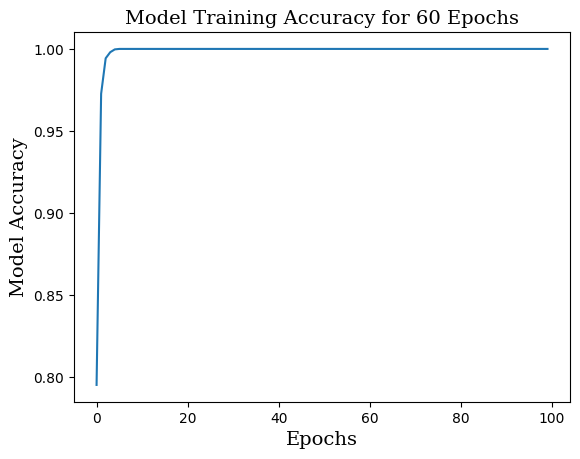

In [8]:
font = {'family': 'serif',
        'color':  'Black',
        'weight': 'normal',
        'size': 14,
        }
from matplotlib import pyplot
plt.title('Model Training Accuracy for 60 Epochs', fontdict=font)
pyplot.plot(history.history['accuracy'])
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Model Accuracy', fontdict=font)
pyplot.show()

In [9]:
val_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
#Confution Matrix and Classification Report
# y_pred = model.predict_classes(X_test)
# from sklearn.metrics import confusion_matrix
# matrix_confusion = confusion_matrix(Y_test, y_pred)

# y_test_arg=np.argmax(Y_test,axis=0)
# Y_pred = np.argmax(model.predict(X_test),axis=0)
# print('Confusion Matrix')
# print(confusion_matrix(y_test_arg, Y_pred))

# print(len(Y_test))
# matrix_confusion = confusion_matrix(Y_test, y_pred)
# Y_test
# y_pred
predictions = np.argmax(model.predict(val_data),axis=1)
# print( predictions.shape )

print( predictions )
# print( y_test )

#  Converting 1-Hot encoding to categorical labels
y_test_categorical = np.where(val_labels==1)[1]
# y_predictions_categorical = np.where(predictions==1)[1]
cf_matrix = confusion_matrix(y_test_categorical, predictions)
from collections import Counter
print(Counter(y_test_categorical))
print(Counter(predictions))


NameError: name 'model' is not defined

In [11]:
import seaborn as sns

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

sns.set(font_scale=1.2) # Adjust to fit
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar_kws={'label': 'Number of Time Windows'})
# csfont = {'fontname':'Comic Sans MS'}
# hfont = {'fontname':'Helvetica'}
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 18}

label_font = {'size':'24'}  # Adjust to fit


#   Title parameters
title_font = {'size':'10'}  # Adjust to fit
# ax.set_title('Confusion Matrix', fontdict=title_font);
ax.set_title('1D-CNN Model Accuracy for Testing Data\n\n', **font);
ax.set_xlabel('\nPredicted Clinician Task ', **font, fontdict=label_font)
ax.set_ylabel('Measured Clinician Task ', **font);

# ## Ticket labels - List must be in alphabetical order
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
ax.xaxis.set_ticklabels(['n-2 Back', 'n-0 Back','n-1 Back','n-3 Back', 'Control']);
ax.yaxis.set_ticklabels(['n-2 Back', 'n-0 Back','n-1 Back','n-3 Back', 'Control']);

# ## Display the visualization of the Confusion Matrix.
import matplotlib

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16.5, 9.5)
# # fig.savefig('test2png.png', dpi=100)
plt.show()

ValueError: cannot reshape array of size 49 into shape (5,5)

# IMAGE DATASET LOADING AND TRAINING END HERE AND 
# 1D dataset training begining from the cell below

In [8]:
#model
# model = Sequential()

# model.add(Conv1D(filters=64, kernel_size=10,activation='relu',kernel_initializer='he_uniform', input_shape=(400,1)))
# model.add(Conv1D(filters=128, kernel_size=10,activation='relu',kernel_initializer='he_uniform'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(2, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=18,activation='relu', input_shape=(300,1)))
# model.add(Conv1D(filters=128, kernel_size=18,activation='relu'))
# # model.add(Conv1D(filters=128, kernel_size=5,activation='relu'))
# model.add(Dropout(0.2))
# model.add(MaxPooling1D(pool_size=14))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## FIRST MODEL ########################################################################
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=12,activation='relu', input_shape=(13200,1)))
# model.add(Conv1D(filters=128, kernel_size=8,activation='relu'))
# # # model.add(Conv1D(filters=128, kernel_size=5,activation='relu'))
# model.add(Dropout(0.3))
# model.add(MaxPooling1D(pool_size=6))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(8, activation='softmax'))
# # optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
# model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# model.summary()

## CNN + LSTM model #####################################################################
# Load pre-trained model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

# FCN

input_shape = (31512,1)
num_classes = 6

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', strides=2))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', strides=2))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', strides=2))
model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', strides=2))
model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', strides=2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()



# FCN + LSTM
# input_shape = (31512, 1)
# num_classes = 6

# # Load the saved FCN model
# saved_model_path = "/ProjectDeepLearning/Code/Testing6FCN+LSTMmodel_EegFnirsEcgEmg/model-epoch-033-valacc-0.977126.h5"
# base_model = load_model(saved_model_path)

# # Exclude the classification layer
# feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
# reshaped_output = tf.keras.layers.Reshape((4, 64))(feature_extractor.output)
# for layer in feature_extractor.layers:
#     layer.trainable = False
# # Create the LSTM model
# model = tf.keras.Sequential()
# model.add(feature_extractor)
# model.add(Reshape((4, 64), input_shape=(4, 64)))
# model.add(LSTM(64))
# model.add(Dense(num_classes, activation='softmax'))

# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 31510, 64)         256       
                                                                 
 conv1d_1 (Conv1D)           (None, 15754, 64)         12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 7876, 128)         24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 3937, 128)         49280     
                                                                 
 conv1d_4 (Conv1D)           (None, 1968, 256)         98560     
                                                                 
 conv1d_5 (Conv1D)           (None, 983, 256)          196864    
                                                                 
 global_average_pooling1d (G  (None, 256)              0

d:\123\aaa\Python\Anaconda\envs\DeepLearningProject\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size= 60
no_epochs = 100

earlystop = EarlyStopping(monitor='val_accuracy', patience=40)
checkpoint = ModelCheckpoint('/ProjectDeepLearning/Code/Testing10FCN+LSTMmodel_EegFnirsEcgEmg/model-epoch-{epoch:03d}-valacc-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')
# Generate the fit model
hist = model.fit(Xtrain, Ytrain, 
                 epochs=no_epochs, 
                 batch_size=batch_size, 
                 validation_data=(Xval, Yval),
                 callbacks=[earlystop, checkpoint])

Epoch 1/100
89/89 [==============================] - ETA: 0s - loss: 1.5936 - accuracy: 0.2683
Epoch 1: val_accuracy improved from -inf to 0.42169, saving model to /ProjectDeepLearning/Code/Testing10FCN+LSTMmodel_EegFnirsEcgEmg\model-epoch-001-valacc-0.421687.h5
89/89 [==============================] - 17s 107ms/step - loss: 1.5936 - accuracy: 0.2683 - val_loss: 1.4586 - val_accuracy: 0.4217
Epoch 2/100
88/89 [============================>.] - ETA: 0s - loss: 1.3290 - accuracy: 0.4102
Epoch 2: val_accuracy improved from 0.42169 to 0.49398, saving model to /ProjectDeepLearning/Code/Testing10FCN+LSTMmodel_EegFnirsEcgEmg\model-epoch-002-valacc-0.493976.h5
89/89 [==============================] - 8s 92ms/step - loss: 1.3289 - accuracy: 0.4111 - val_loss: 1.1990 - val_accuracy: 0.4940
Epoch 3/100
88/89 [============================>.] - ETA: 0s - loss: 1.1670 - accuracy: 0.4956
Epoch 3: val_accuracy improved from 0.49398 to 0.50904, saving model to /ProjectDeepLearning/Code/Testing10FCN+LST

KeyboardInterrupt: 

# Plot Results

In [12]:
# font = {'family': 'serif',
#         'color':  'Black',
#         'weight': 'normal',
#         'size': 14,
#         }

# from matplotlib import pyplot
# plt.title('Model Training Accuracy for 60 Epochs', fontdict=font)
# pyplot.plot(hist.history['accuracy'])
# plt.xlabel('Epochs', fontdict=font)
# plt.ylabel('Model Accuracy', fontdict=font)
# pyplot.show()


# x_train = Xtrain
# y_train = Ytrain
# x_test = Xval
# y_test = Yval
font = {'family': 'serif',
        'color':  'Black',
        'weight': 'normal',
        'size': 14,
        }
model = load_model("/ProjectDeepLearning/Code/Testing7FCN+LSTMmodel_EegFnirsEcgEmg/model-epoch-042-valacc-0.985714.h5")
print(hist)
from matplotlib import pyplot
plt.title('Model Training Accuracy for 60 Epochs', fontdict=font)
pyplot.plot(hist.history['accuracy'])
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Model Accuracy', fontdict=font)
pyplot.show()

NameError: name 'hist' is not defined

In [13]:
predictions = model.predict(X_test)
y_pred = predictions
Y_test = Y_test.astype(int)
Y_test


60/60 [==============================] - 1s 15ms/step


2847    2
1925    5
5937    4
6671    4
9383    5
       ..
773     3
5887    4
2670    5
5425    4
896     3
Name: 31512, Length: 1890, dtype: int32

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
#Confution Matrix and Classification Report
# y_pred = model.predict_classes(X_test)
# from sklearn.metrics import confusion_matrix
# matrix_confusion = confusion_matrix(Y_test, y_pred)

# y_test_arg=np.argmax(Y_test,axis=0)
# Y_pred = np.argmax(model.predict(X_test),axis=0)
# print('Confusion Matrix')
# print(confusion_matrix(y_test_arg, Y_pred))

# print(len(Y_test))
# matrix_confusion = confusion_matrix(Y_test, y_pred)
# Y_test
# y_pred
predictions = np.argmax(model.predict(X_test),axis=1)
# print( predictions.shape )

print( predictions )
# print( y_test )

#  Converting 1-Hot encoding to categorical labels
y_test_categorical = np.where(Y_test==1)[0]
# y_predictions_categorical = np.where(predictions==1)[1]
print(predictions)
cf_matrix = confusion_matrix(Y_test, predictions)
from collections import Counter
print(Counter(Y_test))
print(Counter(predictions))
# print(predictions)

60/60 [==============================] - 1s 18ms/step
[2 5 4 ... 5 4 3]
[2 5 4 ... 5 4 3]
Counter({5: 513, 4: 434, 3: 353, 1: 297, 2: 293})
Counter({5: 496, 4: 442, 3: 357, 2: 299, 1: 296})


In [15]:
def calculate_f_score(confusion_matrix):
    # Convert the confusion matrix to a numpy array for easier computations
    confusion_matrix = np.array(confusion_matrix)
    
    # Calculate the number of classes
    num_classes = len(confusion_matrix)
    
    # Initialize variables for precision, recall, and F-score for each class
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f_score = np.zeros(num_classes)
    
    # Iterate over each class
    for i in range(num_classes):
        # Extract values for the class
        true_positive = confusion_matrix[i, i]
        false_positive = np.sum(confusion_matrix[:, i]) - true_positive
        false_negative = np.sum(confusion_matrix[i, :]) - true_positive
        
        # Calculate precision
        precision[i] = true_positive / (true_positive + false_positive)
        
        # Calculate recall
        recall[i] = true_positive / (true_positive + false_negative)
        
        # Calculate F-score
        f_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    # Calculate the average F-score across all classes
    average_f_score = np.mean(f_score)
    
    return average_f_score

# Calculate F-score
f_score = calculate_f_score(cf_matrix)
print("Average F-score:", f_score)

Average F-score: 0.9866834488204258


# Confusion Matrix for Testing

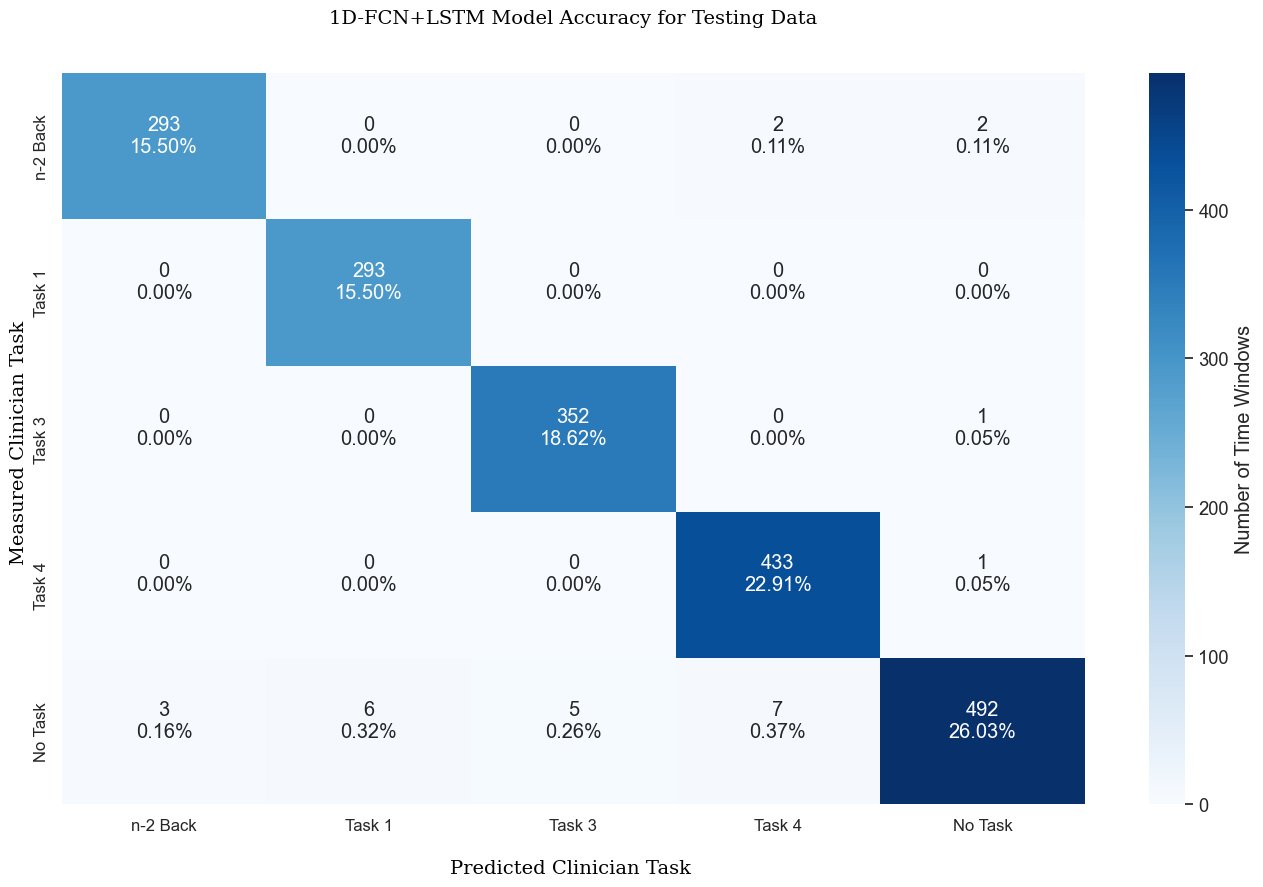

In [16]:
import seaborn as sns

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

sns.set(font_scale=1.2) # Adjust to fit
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar_kws={'label': 'Number of Time Windows'})
# csfont = {'fontname':'Comic Sans MS'}
# hfont = {'fontname':'Helvetica'}
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 18}

label_font = {'size':'24'}  # Adjust to fit


#   Title parameters
title_font = {'size':'10'}  # Adjust to fit
# ax.set_title('Confusion Matrix', fontdict=title_font);
ax.set_title('1D-FCN+LSTM Model Accuracy for Testing Data\n\n', **font);
ax.set_xlabel('\nPredicted Clinician Task ', **font, fontdict=label_font)
ax.set_ylabel('Measured Clinician Task ', **font);

# ## Ticket labels - List must be in alphabetical order
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
ax.xaxis.set_ticklabels(['n-2 Back', 'Task 1','Task 3','Task 4','No Task']);
ax.yaxis.set_ticklabels(['n-2 Back', 'Task 1','Task 3','Task 4','No Task']);

# ## Display the visualization of the Confusion Matrix.
import matplotlib

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16.5, 9.5)
# # fig.savefig('test2png.png', dpi=100)
plt.show()

# [['session_start'], ['start_n-2_back'], ['complete_n-2_back'], ['start_n-0_back'], ['complete_n-0_back'], 
# ['start_n-1_back'], ['complete_n-1_back'], ['start_n-3_back'], ['complete_n-3_back'], ['start_control'], 
# ['complete_control'], ['start_question'], ['complete_question'], ['start_answer'], ['complete_answer'], ['session_complete']]
# ..............................................................................
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test_categorical, predictions)

# ax = plt.subplot()
# sns.set(font_scale=1.5) # Adjust to fit
# sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g"); 
 

# # Labels, title and ticks
# label_font = {'size':'18'}  # Adjust to fit
# ax.set_xlabel('Predicted labels', fontdict=label_font);
# ax.set_ylabel('Observed labels', fontdict=label_font);

# title_font = {'size':'10'}  # Adjust to fit
# ax.set_title('Confusion Matrix', fontdict=title_font);

# ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
# ax.xaxis.set_ticklabels(['n-2 Back', 'n-0 Back','n-1 Back','n-3 Back', 'Control', 'Question', 'Answer','No Task']);
# ax.yaxis.set_ticklabels(['n-2 Back', 'n-0 Back','n-1 Back','n-3 Back', 'Control','Question','Answer','No Task']);

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(16.5, 9.5)
# plt.show()

In [ ]:
x_train = Xtrain
y_train = Ytrain
x_test = Xval
y_test = Yval

# Confusion Matrix for Training

In [ ]:
y_train = np.argmax(model.predict(x_train),axis=1)
print( y_train.shape )
print(y_train)

1879/1879 [==============================] - 5s 3ms/step
(60097,)
[8 8 7 ... 8 8 8]


In [ ]:
print( y_train_pred )
print( y_train )
cf_matrix_train = confusion_matrix(y_train_pred, y_train )

[8 8 7 ... 8 8 8]
[8 8 7 ... 8 8 8]


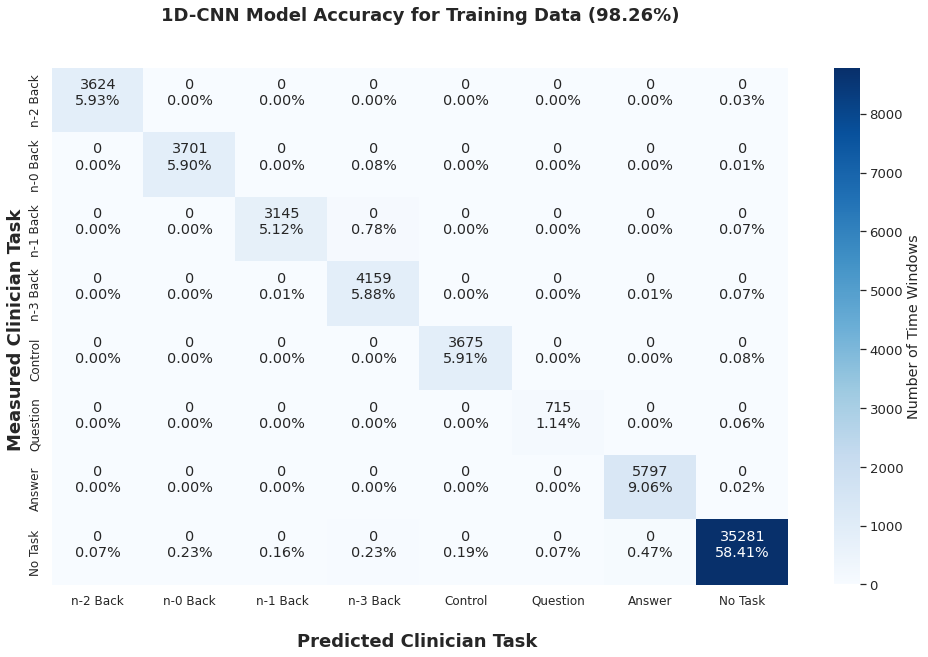

In [ ]:
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_train.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(8,8)

sns.set(font_scale=1.2) # Adjust to fit
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar_kws={'label': 'Number of Time Windows'})
# csfont = {'fontname':'Comic Sans MS'}
# hfont = {'fontname':'Helvetica'}
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

label_font = {'size':'24'}  # Adjust to fit


#   Title parameters
title_font = {'size':'10'}  # Adjust to fit
# ax.set_title('Confusion Matrix', fontdict=title_font);
ax.set_title('1D-CNN Model Accuracy for Training Data (98.26%)\n\n', **font);
ax.set_xlabel('\nPredicted Clinician Task ', **font, fontdict=label_font)
ax.set_ylabel('Measured Clinician Task ', **font);

# ## Ticket labels - List must be in alphabetical order
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
ax.xaxis.set_ticklabels(['n-2 Back', 'n-0 Back','n-1 Back','n-3 Back', 'Control', 'Question', 'Answer','No Task']);
ax.yaxis.set_ticklabels(['n-2 Back', 'n-0 Back','n-1 Back','n-3 Back', 'Control','Question','Answer','No Task']);

# ## Display the visualization of the Confusion Matrix.
import matplotlib

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16.5, 9.5)
# # fig.savefig('test2png.png', dpi=100)
plt.show()